# AutoML Regression


<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

## 0. Paramétrage

In [1]:
#Mise à jour si besoin (redémarrer le kernel ensuite)
#!pip install --upgrade azureml-sdk[automl]

In [2]:
import sys
print("Version Python :", sys.version)

Version Python : 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [3]:
import datetime
now = datetime.datetime.now()
print(now)

2020-07-24 08:00:33.607269


In [4]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.9.0


In [5]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
import azureml.dataprep as dprep
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset

## 1. Création expérimentation

In [6]:
ws = Workspace.from_config()

experiment_name = 'Exemple3-automlregression'
project_folder = './sample_projects/workshop3'

experiment = Experiment(ws, experiment_name)

output = {}
output['Azure ML version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
Azure ML version,1.9.0
Workspace Name,workshopAML2020
Resource Group,workshopAML2020-rg
Location,westeurope
Project Directory,./sample_projects/workshop3
Experiment Name,Exemple3-automlregression


## 2. Chargement des données

In [7]:
from sklearn.datasets import load_boston
boston=load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)

df['target'] = boston.target

In [8]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [10]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [11]:
df.shape

(506, 14)

In [12]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

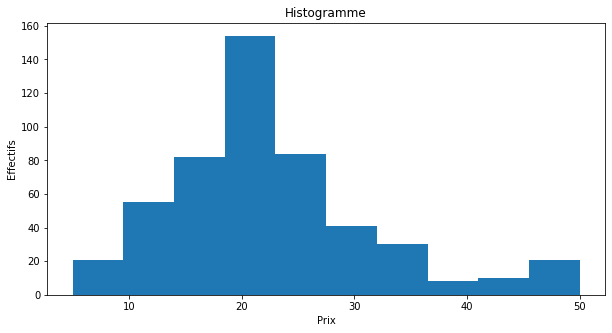

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df.target)
plt.title('Histogramme')
plt.xlabel('Prix')
plt.ylabel('Effectifs')
plt.show()

## 3. Configuration AutoML


> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [14]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cpu_cluster_name = "AutoML"

try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS12_V2',
                                                           max_nodes=6)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [15]:
# Partitionnement des données
from sklearn.model_selection import train_test_split
y_df = df.pop("target")
x_df = df
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=223)

> https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.constants.supportedmodels.regression?view=azure-ml-py

In [16]:
automl_settings = {
    "enable_early_stopping": True, 
    "iterations" : 5,
    "iteration_timeout_minutes": 2,
    "experiment_timeout_minutes": 15,
    "n_cross_validations": 5,
    "primary_metric": 'normalized_root_mean_squared_error', #Autre métrique
    "featurization": 'auto',
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'regression',
                             debug_log = 'automlreg.log',
                             X=x_train.values,
                             y=y_train.values.flatten(),
                             whitelist_models=['LightGBM'], # Whiteliste
                             enable_voting_ensemble=False, # Pas de Voting Ensemble
                             enable_stack_ensemble=False, # Pas de Stack Ensemble
                             **automl_settings
                            )

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


In [17]:
automl_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_bbfa362a-ca0c-4fe2-b160-4b5a5b471d6f

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardi

In [18]:
automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple3-automlregression,AutoML_bbfa362a-ca0c-4fe2-b160-4b5a5b471d6f,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
# Widget AutoML pour visualiser les résultats autoML
from azureml.widgets import RunDetails
RunDetails(automl_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## 5. Référencement du meilleur modèle

In [21]:
best_run, fitted_model = automl_run.get_output()
print("Best Run :")
print(best_run)

Best Run :
Run(Experiment: Exemple3-automlregression,
Id: AutoML_bbfa362a-ca0c-4fe2-b160-4b5a5b471d6f_2,
Type: None,
Status: Completed)


In [22]:
print(fitted_model)

RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser....525, silent=True, subsample=0.9,
         subsample_for_bin=200000, subsample_freq=6, verbose=-1))]),
          stddev=None)


In [23]:
# Liste des métriques
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

- root_mean_squared_log_error = 0.14369166586776655
- mean_absolute_percentage_error = 11.122383549736005
- explained_variance = 0.8669463386770468
- normalized_root_mean_squared_error = 0.07199246230940634
- mean_absolute_error = 2.235884874064067
- root_mean_squared_error = 3.239660803923285
- r2_score = 0.8652411523249226
- normalized_root_mean_squared_log_error = 0.06714356234342515
- normalized_mean_absolute_error = 0.049686330534757045
- median_absolute_error = 1.5790631349740534
- normalized_median_absolute_error = 0.035090291888312294
- spearman_correlation = 0.9116648194704483
- predicted_true = aml://artifactId/ExperimentRun/dcid.AutoML_bbfa362a-ca0c-4fe2-b160-4b5a5b471d6f_2/predicted_true
- residuals = aml://artifactId/ExperimentRun/dcid.AutoML_bbfa362a-ca0c-4fe2-b160-4b5a5b471d6f_2/residuals


In [24]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='Exemple3-AutoML-Regression',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'R2': best_run_metrics['r2_score'], 'RMSE': best_run_metrics['normalized_root_mean_squared_error']})

Model(workspace=Workspace.create(name='workshopAML2020', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='workshopAML2020-rg'), name=Exemple3-AutoML-Regression, id=Exemple3-AutoML-Regression:14, version=14, tags={'Training context': 'Azure Auto ML'}, properties={'R2': '0.8652411523249226', 'RMSE': '0.07199246230940634'})

> Les modèles sont visibles depuis le studio Azure ML.

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">